In [123]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline de rendu : 15 octobre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

Octave Jeanne, Théo Basséras

In [148]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy
import IPython.display as ipd

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [149]:
sampling_frequency, amplitude = scipy.io.wavfile.read(r"coloniedefourmies.wav")
ipd.Audio(  data = amplitude,
            rate = sampling_frequency)


<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
    </div>

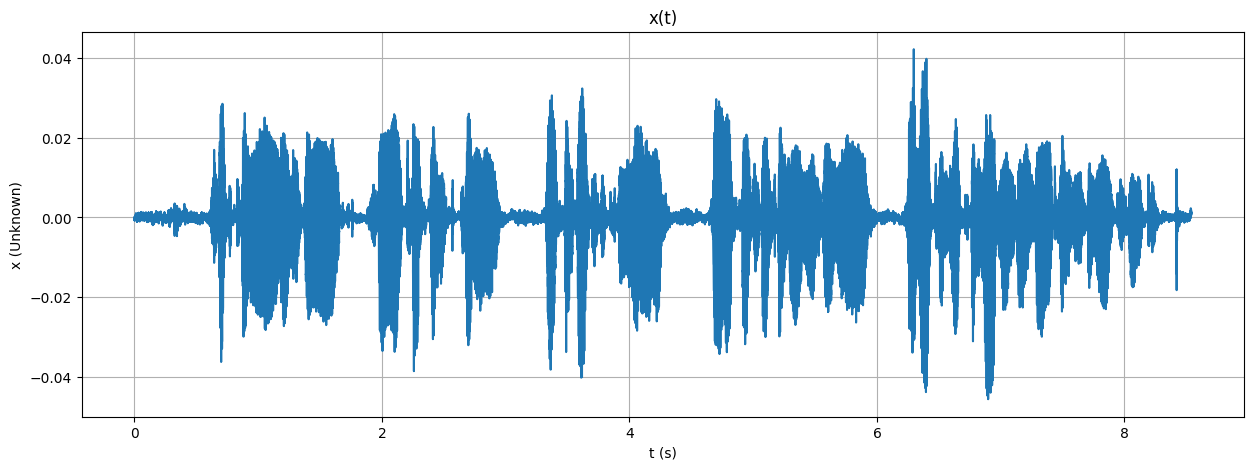

In [150]:
time = np.array([0 + i/sampling_frequency for i in range(len(amplitude))])
plt.figure(figsize = (15, 5))
plt.plot(time, amplitude)
plt.title('x(t)')
plt.xlabel('t (s)')
plt.ylabel('x (Unknown)')
plt.grid()
plt.show()

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

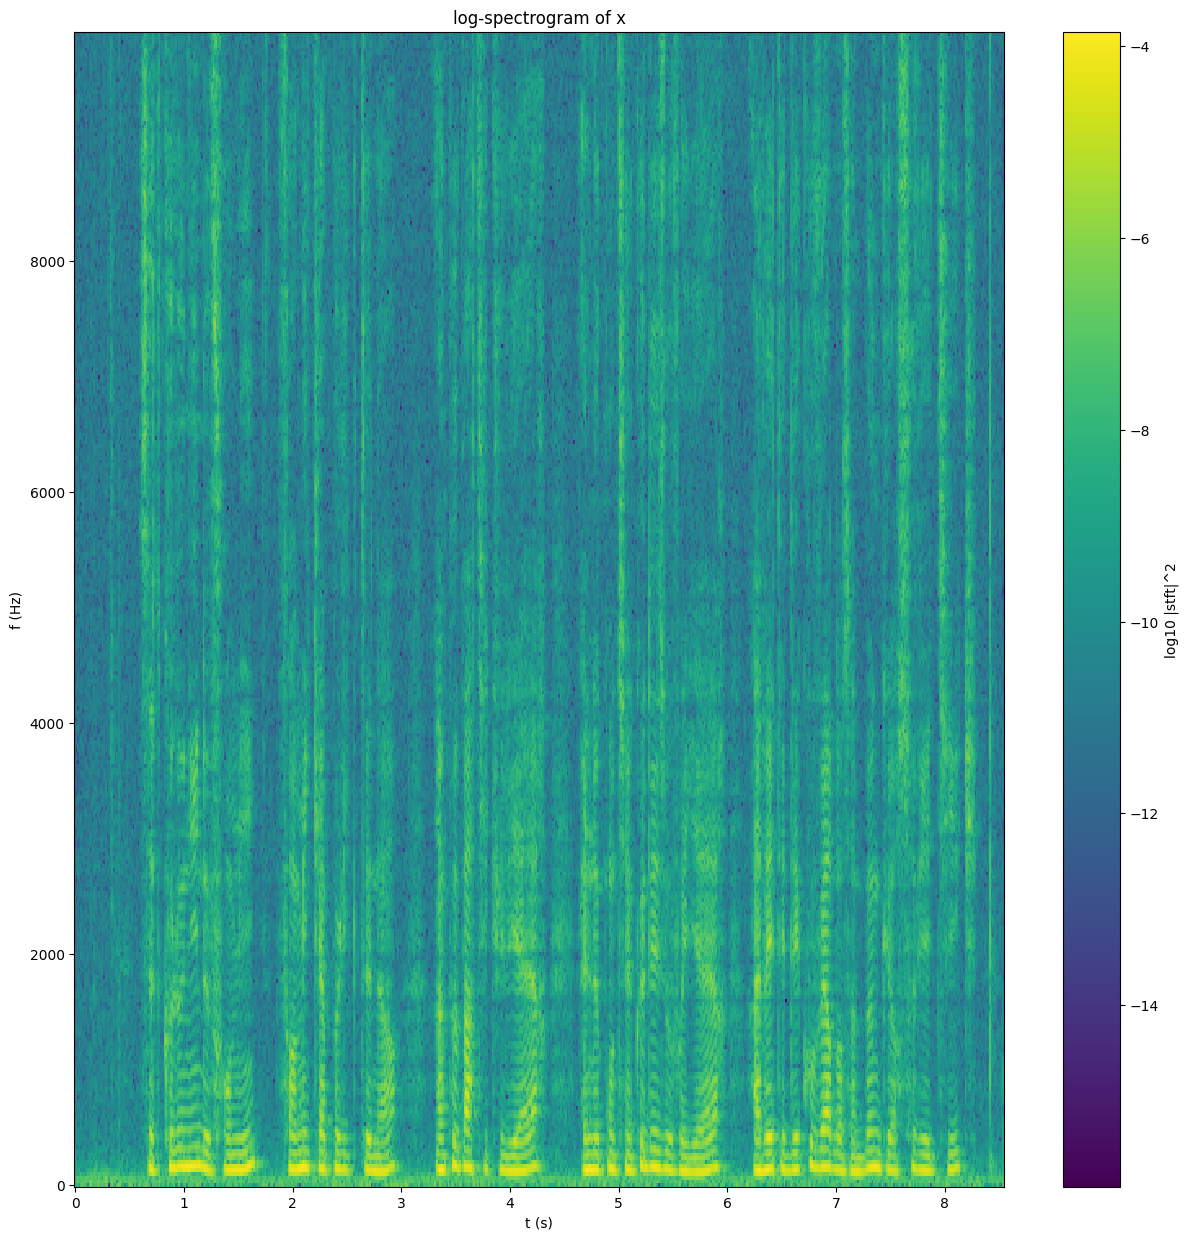

In [157]:

# Select the window size using time rather than number of points to preserve physical intuition
window_time_size = 0.03
window_sample_size = sampling_frequency*window_time_size

frequencies, time, short_time_fourier_transform = scipy.signal.stft(    amplitude,
                                                                        fs = sampling_frequency,
                                                                        nperseg = window_sample_size,
                                                                        nfft = window_sample_size)

# The spectrogram is defined as the squared module of the short time fourier transform
spectrogram = np.abs(short_time_fourier_transform)**2

# Unusual values above 12500 Hz (optionnal cut)
# Moreover, the human ear tends to cut frequenies above 10kHz so we know that the values above this limit are not likely to be pertinent for processing
# audible noise
frequency_upper_bound = 10000

frequencies = frequencies[frequencies<frequency_upper_bound]
spectrogram = spectrogram[:len(frequencies),:]

# The contrast is low at linear scale so we compensate by composing by log10
log_spectrogram = np.log10(spectrogram)

plt.figure(figsize = (15, 15))                  # Better to have a bigger height than risk loosing info by cutting at a frequency that is too low
plt.pcolor(time, frequencies, log_spectrogram)
plt.title('log-spectrogram of x')
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.colorbar(label = 'log10 |stft|^2')
plt.show()




### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

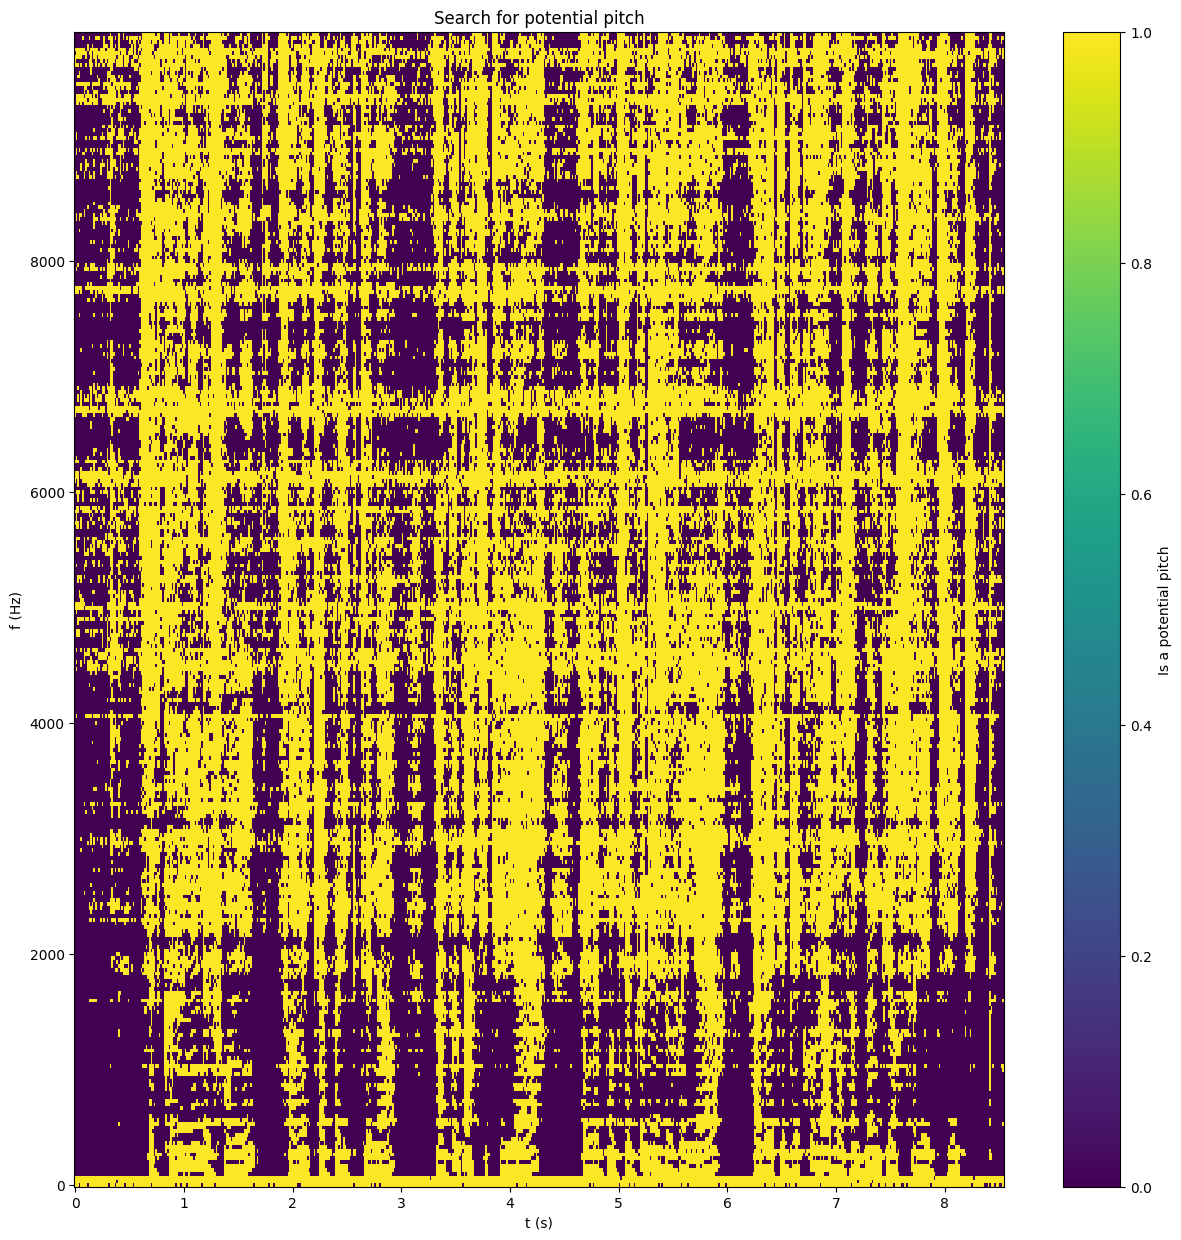

In [158]:
# Test : the pitch is supposed to cary the most power
# -> Does not work in practice ( due to unusual values from the mean of measure ??)
# May be usefull to check for harmonic first and then get the harmonic that carries the most power (i.e the lowest one)

tolerance = 0.5
max_log_DSP_windowize = np.max(log_spectrogram,
                               axis = 1)

# Get the max spd at each time_steps
max_log_DSP_windowize = np.transpose(np.array([max_log_DSP_windowize for i in range(log_spectrogram.shape[1])]))

# Get all the potential pitch at each time steps 
# The pitch is supposed to carry some significant power so it is likely that it has a power that is near the max
frequency_in_max_spd = log_spectrogram.copy()
frequency_in_max_spd[frequency_in_max_spd<(max_log_DSP_windowize + tolerance*max_log_DSP_windowize)]     = 0
frequency_in_max_spd[~(frequency_in_max_spd==0)]  = 1


plt.figure(figsize = (15, 15))                  # Better to have a bigger height than risk loosing info by cutting at a frequency that is too low
plt.pcolor(time, frequencies, frequency_in_max_spd)
plt.title('Search for potential pitch')
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.colorbar(label = 'Is a potential pitch')
plt.show()

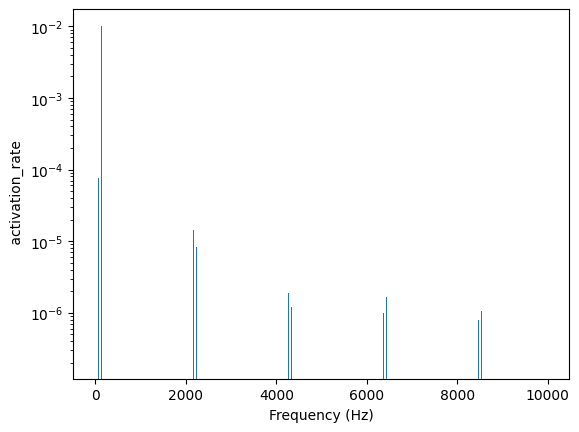

In [159]:
# Idea : The person is spoking through most of the audio and its pitch is not supposed to change overtime
# Thus the pitch has to "active" (i.e in the max of the spd) at most time steps
# However there is too much noise so a brutal count won't do the trick
# To compensate we use a ponderation based on the spd value (if it has some high power than it should count more)

# We will call the weighted count the "activation rate"

activation_rate = np.zeros(len(frequencies))

for time_step in range(len(time)):
    # in_max_count += frequency_in_max_spd[:,time_step] * amp_weight * log_spectrogram[:,time_step]
    activation_rate += frequency_in_max_spd[:,time_step] * spectrogram[:,time_step]

plt.bar(frequencies, activation_rate, width=0.8, align='center')
plt.xlabel("Frequency (Hz)")
plt.ylabel(" activation_rate")
plt.yscale('log')                       # Set the scale to log to emphasize contrast
plt.show()

In [160]:

pitch_index = list(activation_rate).index(max(activation_rate))
pitch = frequencies[pitch_index]
pitch

np.float64(133.33333333333334)

## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [128]:
donnees = np.load('signaux_impulsions.npz')
print(donnees)
signaux = donnees['data']
labels = donnees['labels']
print(signaux,labels)
print(signaux.shape)

NpzFile 'signaux_impulsions.npz' with keys: data, labels
[[ 0.29974805 -0.12125915  0.22815121 ... -0.29491999  0.35442665
  -0.115722  ]
 [-0.34282489  0.43933608  0.14600521 ...  0.46720926 -0.27130464
  -0.72383238]
 [ 0.27976145  0.00458407  0.42789069 ...  0.44733965  0.62510333
  -0.10286149]
 ...
 [ 0.04355831 -0.1904187   0.15759083 ...  0.23340604  0.25780205
  -0.31590456]
 [ 0.18310512 -0.16951991  0.0898067  ...  0.12355812  0.38930594
   0.06933823]
 [ 0.61154135 -0.07164611  0.02346849 ...  0.2375444  -0.30161418
   0.11703782]] [0. 0. 0. ... 0. 1. 1.]
(10000, 1000)


## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

```python
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
```

On suppose que notre signal contient une impulsion (de l'information) s'il est assez puissant, en d'autres termes si son énergie est supérieure à un certain seuil.

In [129]:
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
    # Calcul de l’énergie du signal
    energie = np.sum(signal.astype(float)**2)
    
    # Comparaison au seuil
    return energie > seuil

# Test : seuil choisi empiriquement
seuil = 0.9 * np.sum(amplitude**2)  # ex : 10% de l’énergie totale max
impulsion_presente = contient_impulsion_energie(amplitude, seuil)

print("Impulsion détectée :", impulsion_presente)

Impulsion détectée : True


<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

In [130]:

#seuil = 0.9 * np.sum(amplitude**2)  
seuil =2* np.sum(signaux[-1,:]**2)  
estimated_labels=[]
for k in range (len(signaux)):
    estimated_labels.append(bool(contient_impulsion_energie(signaux[k,:], seuil)))



<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [131]:
difference=estimated_labels-labels
VP=0
FP=0
VN=0
FN=0




for k in range(len(estimated_labels)):
    if difference[k]>0:
        FP+=1
    elif difference[k]==0 and estimated_labels[k]==1:
        VP+=1
    if difference[k]<0:
        FN+=1
    elif difference[k]==0 and estimated_labels[k]==0:
        VN+=1

print("VP=",VP,", FP=",FP,", VN=",VN,", FN=",FN)
    


VP= 2814 , FP= 1892 , VN= 3104 , FN= 2190


## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


In [133]:


frequency_upper_bound = 10000
signal=signaux[-1]


# Fenêtrage
window = np.hamming(len(signal))
signal = signal * window

# FFT
spectrum = np.abs(np.fft.rfft(signal))
freqs = np.fft.rfftfreq(len(signal))

# Restreindre à la plage du pitch

spectrum_roi = spectrum[freqs<frequency_upper_bound]
freqs_roi = freqs[freqs<frequency_upper_bound]

# Chercher le pic principal
peak_amp = np.max(spectrum_roi)

seuil=0.5*peak_amp




def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
    
    
    # Fenêtrage
    window = np.hamming(len(signal))
    signal = signal * window

    # FFT
    spectrum = np.abs(np.fft.rfft(signal))**2
    freqs = np.fft.rfftfreq(len(signal))
    
    log_spectrogram = np.log10(spectrum)
    # Restreindre à la plage du pitch

    spectrum_roi = spectrum[freqs<frequency_upper_bound]
    freqs_roi = freqs[freqs<frequency_upper_bound]
    
    # Chercher le pic principal
    peak_amp = np.max(spectrum_roi) 

    peak_freq = freqs_roi[np.argmax(spectrum_roi)]
    
    # Retourne True si le pic dépasse le seuil
    return peak_amp > seuil



#seuil = 0.9 * np.sum(amplitude**2)  
#seuil =2* np.sum(signaux[-1,:]**2)




estimated_labels=[]
for k in range (len(signaux)):
    estimated_labels.append(bool(contient_impulsion_spectrogramme(signaux[k,:], seuil)))



difference=estimated_labels-labels
VP=0
FP=0
VN=0
FN=0




for k in range(len(estimated_labels)):
    if difference[k]>0:
        FP+=1
    elif difference[k]==0 and estimated_labels[k]==1:
        VP+=1
    if difference[k]<0:
        FN+=1
    elif difference[k]==0 and estimated_labels[k]==0:
        VN+=1

print("VP=",VP,", FP=",FP,", VN=",VN,", FN=",FN)

print(sum(labels))


VP= 5002 , FP= 4953 , VN= 43 , FN= 2
5004.0


In [ ]:

'''
frequency_upper_bound = 10000
signal=signaux[-1]



tolerance=0.5
# Fenêtrage
window = np.hamming(len(signal))
signal = signal * window



frames=frame_signal(signal, frame_size=20, hop_size=20) #20ms for one frame
# FFT
spectrum = np.abs(np.fft.rfft(frames))**2

frame_size = 20        # samples per frame
Fs = 1000              # sampling rate in Hz

freqs = np.fft.rfftfreq(frame_size, d=1/Fs)
#freqs = np.fft.rfftfreq(len(spectrum[0]))


spectrogram = spectrum[:,freqs<frequency_upper_bound]
freqs = freqs[freqs<frequency_upper_bound]

log_spectrogram = np.log10(spectrum)

# Get the max spd at each time_steps
max_log_DSP_windowize = np.transpose(np.array([frames for i in range(spectrum.shape[1])]))

# Max per frame
max_log_DSP_windowize = np.max(log_spectrogram, axis=1, keepdims=True)

# Thresholding
frequency_in_max_spd = np.where(
    log_spectrogram >= max_log_DSP_windowize * (1 - tolerance),
    1, 0
)

# Get all the potential pitch at each time steps 
# The pitch is supposed to carry some significant power so it is likely that it has a power that is near the max

frequency_in_max_spd[~(frequency_in_max_spd==0)]  = 1

activation_rate = np.sum(frequency_in_max_spd * spectrogram, axis=0)  # sum over frequency bins


peak_amp_mod = np.max(activation_rate)

seuil=0.2*peak_amp_mod




def frame_signal(signal, frame_size, hop_size):
    signal = np.array(signal)  # ensure numpy array
    num_frames = 1 + (len(signal) - frame_size) // hop_size
    frames = np.stack([
        signal[i*hop_size : i*hop_size + frame_size]
        for i in range(num_frames)
    ])
    return frames

#Version optimisée du calcul du pitch

def contient_impulsion_spectrogramme_mod(signal: np.ndarray, seuil: float) -> bool:
    
    tolerance=0.5
    # Fenêtrage
    window = np.hamming(len(signal))
    signal = signal * window

    

    frames=frame_signal(signal, frame_size=20, hop_size=20) #20ms for one frame
    # FFT
    spectrum = np.abs(np.fft.rfft(frames))**2

    frame_size = 20        # samples per frame
    Fs = 1000              # sampling rate in Hz

    freqs = np.fft.rfftfreq(frame_size, d=1/Fs)
    #freqs = np.fft.rfftfreq(len(spectrum[0]))
    
   
    spectrogram = spectrum[:,freqs<frequency_upper_bound]
    freqs = freqs[freqs<frequency_upper_bound]

    log_spectrogram = np.log10(spectrum)
    
    # Get the max spd at each time_steps
    max_log_DSP_windowize = np.transpose(np.array([frames for i in range(spectrum.shape[1])]))

    # Max per frame
    max_log_DSP_windowize = np.max(log_spectrogram, axis=1, keepdims=True)

    # Thresholding
    frequency_in_max_spd = np.where(
        log_spectrogram >= max_log_DSP_windowize * (1 - tolerance),
        1, 0
    )

    # Get all the potential pitch at each time steps 
    # The pitch is supposed to carry some significant power so it is likely that it has a power that is near the max
    
    frequency_in_max_spd[~(frequency_in_max_spd==0)]  = 1

    activation_rate = np.sum(frequency_in_max_spd * spectrogram, axis=0)  # sum over frequency bins


     # Restreindre à la plage du pitch
    return(max(activation_rate)>seuil)




#seuil = 0.9 * np.sum(amplitude**2)  
#seuil =2* np.sum(signaux[-1,:]**2)




estimated_labels=[]
for k in range (len(signaux)):
    estimated_labels.append(bool(contient_impulsion_spectrogramme_mod(signaux[k,:], seuil)))



difference=estimated_labels-labels
VP=0
FP=0
VN=0
FN=0




for k in range(len(estimated_labels)):
    if difference[k]>0:
        FP+=1
    elif difference[k]==0 and estimated_labels[k]==1:
        VP+=1
    if difference[k]<0:
        FN+=1
    elif difference[k]==0 and estimated_labels[k]==0:
        VN+=1

print("VP=",VP,", FP=",FP,", VN=",VN,", FN=",FN)
    


VP= 4141 , FP= 2072 , VN= 2924 , FN= 863


<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

## <div class=consignes> Comparaison des méthodes </sdivs>

<div class=consignes>Pour une méthode de détection et un seuil donné, la précision est définie comme: 
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp\text{Signaux détectés comme positifs }}$$
et le rappel comme:
$$ \frac{\sharp\text{Signaux détectés comme contenant une impulsion qui en contiennent effectivement une}}{\sharp \text{Signaux contenant une impulsions}} $$
    
</div>

<div class=consignes> Donnez une interprétation de ces deux métriques </div>

La première métrique permet de savoir sur les signaux détecté quel pourcentage est correct. Par exemple si on détecte 100 impulsions alors uniquement rappel*100 sera le nombre de véritable impulsion parmi celle détecté ou encore si on sélectionne une impulsion parmi les 100 détectés  alors sa probabilité d'être une véritable impulsion est précision.


La seconde métrique permet d'avoir une idée de combien de signaux sont détectés par rapport au nombre de signaux total. En d'autres estime le pourcentage de signaux qu'on a manqué, qu'on n'a pas détecté. En d'autres termes, si notre a 100 impulsions si on choisit une impulsion parmi celles ci la probabilité qu'elle soit détectée est rappel.



<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>

On observe que l'on est plus précis en utilisant la méthode du spectrogramme que pour la méthode de l'énergie (à rappel fixé on a une précision plus grande pour la méthode utilisant le spectrogramme que pour la méthode utilisant l'energie).




Remarques:
 
1. Les points 0 pour la courbe de l'énergie est due au fait qu'à partir d'un seuil trop grand on n'accepte plus aucun signal.

2. On remarque que le rappel=1 est atteint au même niveau pour chacun des deux signaux, en effet c'est le cas où le seuil est très bas donc on accepte tous les signaux, de ce fait puisque le rappel = P(probabilité d'accepter un signal et ce signal est une impulsion)>=P(probabilité d'accepter un signal)=1 (dans le cas où le seuil est très faible)

3. Il semble plus simple de trouver le seuil pour la méthode de l'énergie que pour la méthode du spectrogramme. Ceci peut être du au bruit qui fait croire que l'on a une harmonique de puissance élevée, de ce fait on pourrait utiliser une méthode de corrélation (en effectuant l'autocorélation du signal)  afin de supprimer le bruit.

4. Il semble que la courbe (precision, rappel) soit une droite pour un rappel entre 0.65 et 0.95 (et une précison entre 0.6 et 0.95) pour la méthode du spectrogramme.

   



    

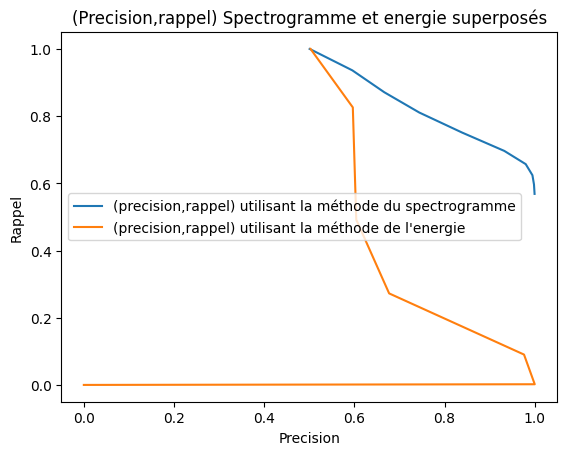

In [146]:
precision_spectro=[]
rappel_spectro=[]

precision_spectro_mod=[]
rappel_spectro_mod=[]


precision_energie=[]
rappel_energie=[]


N=10 #number of points for the threshold
start=0.1 #starting point of the
end=10

k=4

seuil_spectro_list=np.linspace(start*peak_amp*k,end*peak_amp*k,N)
#seuil_spectro_list_mod=np.linspace(start*peak_amp_mod,end*peak_amp_mod,N)
seuil_energie_list =np.linspace(start* np.sum(signaux[-1,:]**2),end* np.sum(signaux[-1,:]**2),N)





for i in range(len(seuil_energie_list)):
    seuil_energie=seuil_energie_list[i]
    seuil_spectro=seuil_spectro_list[i]
    #seuil_spectro_mod=seuil_spectro_list_mod[i]

    estimated_labels_spectro=[]
    #estimated_labels_spectro_mod=[]
    estimated_labels_energie=[]
    for k in range (len(signaux)):
        estimated_labels_spectro.append(bool(contient_impulsion_spectrogramme(signaux[k,:], seuil_spectro)))
        #estimated_labels_spectro_mod.append(bool(contient_impulsion_spectrogramme_mod(signaux[k,:], seuil_spectro_mod)))
        estimated_labels_energie.append(bool(contient_impulsion_energie(signaux[k,:], seuil_energie)))



    difference_spectro=estimated_labels_spectro-labels
    #difference_spectro_mod=estimated_labels_spectro_mod-labels
    difference_energie=estimated_labels_energie-labels
    VP_spectro=0
    FP_spectro=0
    VN_spectro=0
    FN_spectro=0

    VP_spectro_mod=0
    FP_spectro_mod=0
    VN_spectro_mod=0
    FN_spectro_mod=0

    VP_energie=0
    FP_energie=0
    VN_energie=0
    FN_energie=0


    # for k in range(len(estimated_labels)):
    #     if difference_spectro[k]>0:
    #         FP_spectro+=1
    #     elif difference_spectro[k]==0 and estimated_labels[k]==1:
    #         VP_spectro+=1
    #     if difference_spectro[k]<0:
    #         FN_spectro+=1
    #     elif difference_spectro[k]==0 and estimated_labels[k]==0:
    #         VN_spectro+=1

    for k in range(len(labels)):
        est = estimated_labels_spectro[k]
        true = labels[k]
        
        if est == 1 and true == 1:
            VP_spectro += 1
        elif est == 1 and true == 0:
            FP_spectro += 1
        elif est == 0 and true == 1:
            FN_spectro += 1
        elif est == 0 and true == 0:
            VN_spectro += 1

        
    # for k in range(len(estimated_labels)):
    #     if difference_spectro_mod[k]>0:
    #         FP_spectro_mod+=1
    #     elif difference_spectro[k]==0 and estimated_labels[k]==1:
    #         VP_spectro_mod+=1
    #     if difference_spectro[k]<0:
    #         FN_spectro_mod+=1
    #     elif difference_spectro[k]==0 and estimated_labels[k]==0:
    #         VN_spectro_mod+=1

    


    VP_energie = FP_energie = FN_energie = VN_energie = 0

    # Loop through each sample
    for k in range(len(labels)):
        est = estimated_labels_energie[k]  # your predicted label
        true = labels[k]                    # ground truth label

        if est == 1 and true == 1:
            VP_energie += 1
        elif est == 1 and true == 0:
            FP_energie += 1
        elif est == 0 and true == 1:
            FN_energie += 1
        elif est == 0 and true == 0:
            VN_energie += 1

    precision_spectro.append(VP_spectro/(1e-10+VP_spectro+FP_spectro))
    rappel_spectro.append(VP_spectro/(sum(labels)+1e-10))
    # print(VP_spectro,sum(labels))

    # print(len(labels),len(estimated_labels_energie),len(estimated_labels_spectro))

    # precision_spectro_mod.append(VP_spectro_mod/(VP_spectro_mod+FP_spectro_mod))
    # rappel_spectro_mod.append(VP_spectro_mod/sum(labels))



    precision_energie.append(VP_energie/(VP_energie+FP_energie+1e-10))
    rappel_energie.append(VP_energie/(sum(labels)+1e-10))




# plt.plot(seuil_spectro_list,rappel_spectro, label="Rappel utilisant la technique du spectrogramme")
# plt.plot(seuil_energie_list,rappel_energie, label="Rappel utilisant la technique de l'énergie")
# plt.title("Precision")
# plt.xlabel("seuil")
# plt.ylabel("Precision")
# plt.show()

# plt.plot(seuil_spectro_list,precision_spectro, label="Precision utilisant la technique du spectrogramme")
# plt.plot(seuil_energie_list,precision_energie, label="Precision utilisant la technique de l'énergie")
# plt.title("Rappel")
# plt.xlabel("seuil")
# plt.ylabel("Rappel")
# plt.legend()
# plt.show()


# plt.plot(precision_spectro,rappel_spectro, label="(precision,rappel) utilisant la méthode du spectrogramme")
# plt.title("(Precision,rappel) Spectrogramme et energie superposés")
# plt.xlabel("Precision")
# plt.ylabel("Rappel")
# plt.legend()
# plt.show()

# plt.plot(precision_energie,rappel_energie, label="(precision,rappel) utilisant la méthode de l'energie")
# plt.title("(Precision,rappel) Energie")
# plt.xlabel("Precision")
# plt.ylabel("Rappel")
# plt.legend()
# plt.show()




plt.plot(precision_spectro,rappel_spectro, label="(precision,rappel) utilisant la méthode du spectrogramme")
#plt.plot(precision_spectro_mod,rappel_spectro_mod, label="(precision,rappel) utilisant la méthode du spectrogramme modifié")
plt.plot(precision_energie,rappel_energie, label="(precision,rappel) utilisant la méthode de l'energie")
plt.title("(Precision,rappel) Spectrogramme et energie superposés")
plt.xlabel("Precision")
plt.ylabel("Rappel")
plt.legend()
plt.show()

# print(precision_energie,rappel_energie)
